### Import Necessary Libraries

In [3]:
import os
import re
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn   
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torchsummary import summary
import torchvision.models as models
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset 

### Gather Image Dataset

In [4]:
dataset_path = 'dataset'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')

label_dict = {"no": 0, "sphere": 1, "vort": 2}
reverse_label_dict = {0: "no", 1: "sphere", 2: "vort"}
train_imgs, train_classes = [], []
val_imgs, val_classes = [], []

for label, class_idx in label_dict.items():
    folder_path = os.path.join(train_path, label)

    npy_files = sorted(os.listdir(folder_path), key=lambda file: list(map(int, re.findall('\d+', file)))[0])

    for i in range(len(npy_files)):
        train_imgs.append(np.load(os.path.join(folder_path, npy_files[i])))
        train_classes.append(class_idx)

train_imgs = np.array(train_imgs, dtype=np.float32)
train_classes = np.array(train_classes, dtype=np.int64)

for label, class_idx in label_dict.items():
    folder_path = os.path.join(val_path, label)

    npy_files = sorted(os.listdir(folder_path), key=lambda file: list(map(int, re.findall('\d+', file)))[0])

    for npy_file in npy_files:
        np_img = np.load(os.path.join(folder_path, npy_file))
        val_imgs.append(np_img)
        val_classes.append(class_idx)

val_imgs = np.array(val_imgs, dtype=np.float32)
val_classes = np.array(val_classes, dtype=np.int64)

### TensorDataset, Dataloader

In [5]:
train_dataset = TensorDataset(torch.tensor(train_imgs, dtype=torch.float32), torch.tensor(train_classes, dtype=torch.int32))
val_dataset = TensorDataset(torch.tensor(val_imgs, dtype=torch.float32), torch.tensor(val_classes, dtype=torch.int32))

batchSize = 16
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=True)

### Example Image Visualization

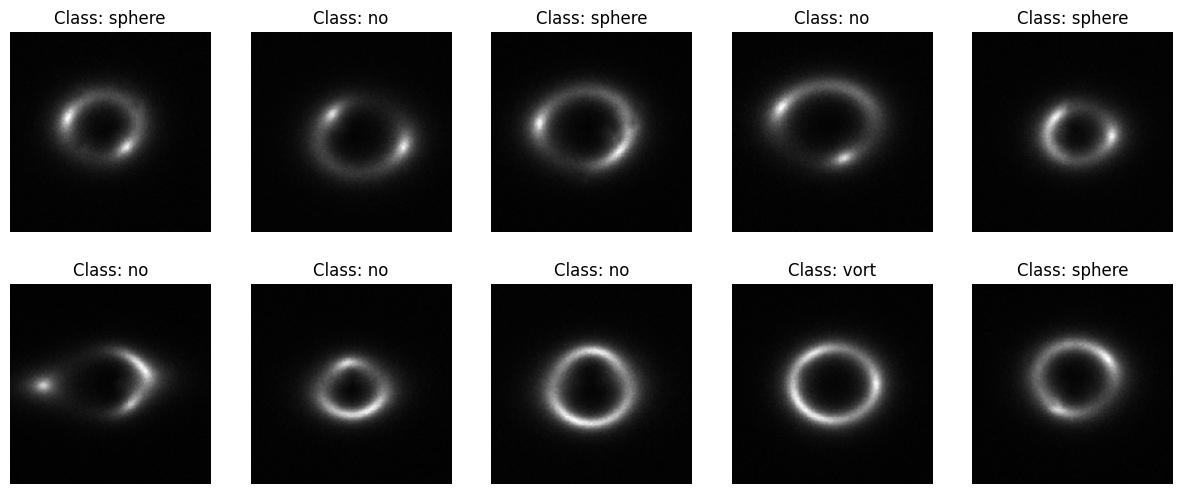

In [6]:
X, y = next(iter(train_loader))

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    ax[i//5][i%5].imshow(X[i].numpy().squeeze(), cmap='gray')
    ax[i//5][i%5].set_title(f"Class: {reverse_label_dict[y[i].item()]}")
    ax[i//5][i%5].axis('off')

### AlexNet, VGG-16, EfficientNet with Pretrained Weights

In [7]:
%%script echo skipping 
device = "cuda" if torch.cuda.is_available() else "cpu"

########### Model 1: AlexNet ###########

model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")
model.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
model.to(device)

## BEST ACCURACY: 34.56 %

########### Model 2: VGG-16 ###########

model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
model.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
model.to(device)

## BEST ACCURACY: 34.56 %

#######################################

########### Model 3: EfficientNet ###########

model = models.efficientnet_b7(weights="EfficientNet_B7_Weights.IMAGENET1K_V1")

model.features[0][0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[1] = nn.Linear(in_features=2560, out_features=3, bias=True)
model.to(device)

## BEST ACCURACY: 34.56 %

#############################################

lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

skipping


### Resnet-18 with Pretrained-weights

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, out_features=3, bias=True)
model.to(device)

lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Summary of the Model: Resnet 18
# summary(model, input_size = (1, 150, 150), device="cuda")

### Train function

In [9]:
def trainModel(model, lossfn, optimizer, iteration):
    epochs = iteration

    trainAcc, trainLoss = [], []

    iteration_count = 0
    total_iterations = len(train_loader) * epochs

    with tqdm(total=total_iterations, desc="Training Progress") as pbar:

        for _ in range(epochs):
            model.train()
            batchAcc, batchLoss = [], []

            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                yHat = model(X)
                loss = lossfn(yHat, y.to(torch.int64))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batchLoss.append(loss.item())

                matches = torch.argmax(yHat, axis=1) == y
                matchNumeric = matches.float().detach()
                accuracy = 100 * torch.mean(matchNumeric)
                batchAcc.append(accuracy.item())

                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_train_loss = np.mean(batchLoss)
                    avg_train_acc = np.mean(batchAcc)
                    trainLoss.append(avg_train_loss)
                    trainAcc.append(avg_train_acc)
                    pbar.set_postfix_str(f"Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.2f}%")
                pbar.update(1)

    checkpoint = {
        "weights": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "task_1_weights.pth")

    return trainLoss, trainAcc, model

### Training the network

In [10]:
trainLoss, trainAcc, model = trainModel(model, lossfn, optimizer, iteration=30)

Training Progress: 100%|██████████| 56250/56250 [21:20<00:00, 43.91it/s, Loss: 0.0210, Acc: 99.26%]


### Training Loss and Accuracy Plot

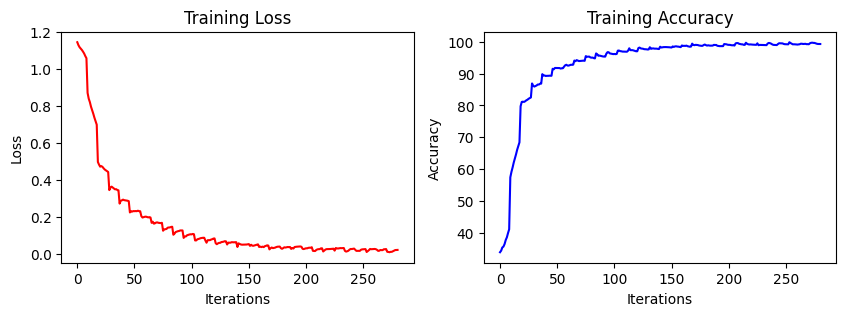

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ax[0].plot(trainLoss, "r-")
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")

ax[1].plot(trainAcc, "b-")
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Accuracy")

plt.show()

### Loading Pretrained Weights, One Hot Encoding

In [12]:
checkpoint_path = "task_1_weights.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)

model.load_state_dict(checkpoint["weights"])

model.eval()
all_logits, all_labels, valAcc = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device).to(torch.int64)

        logits = model(images)
        loss = lossfn(logits, labels)
        probs = F.softmax(logits, dim=1)

        all_logits.append(probs.cpu())
        all_labels.append(labels.cpu())
        
        matches = torch.argmax(logits, axis=1) == labels
        matchNumeric = matches.float().detach()
        accuracy = 100 * torch.mean(matchNumeric)
        valAcc.append(accuracy.item())

all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim=0)

num_classes = 3
val_label_one_hot = F.one_hot(all_labels.clone().detach(), num_classes=num_classes).float()

### Evaluation Metrics (ROC, AUC, Probability Histograms)

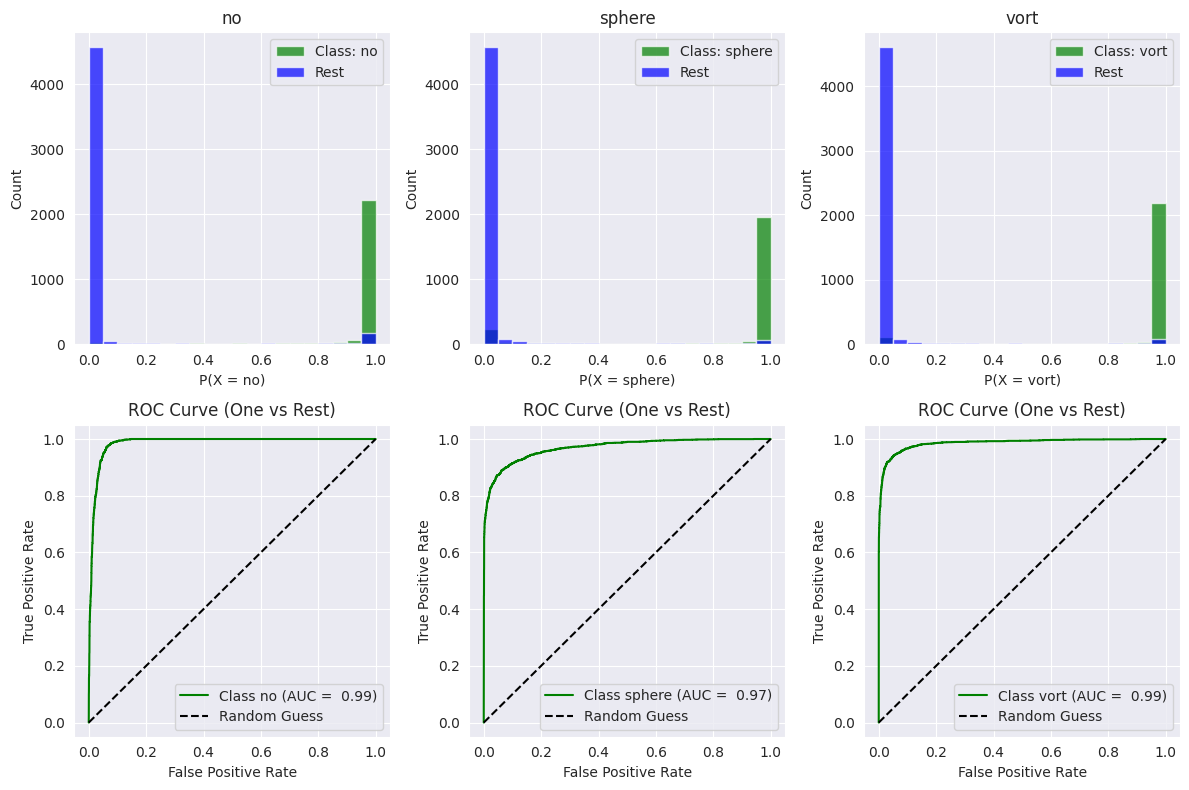

In [13]:
sns.set_style("darkgrid")
_, ax = plt.subplots(nrows=2, ncols=num_classes, figsize=(num_classes*4, 8))

for i in range(num_classes):
    class_probs = all_logits[:, i].numpy()
    true_class = val_label_one_hot[:, i].numpy() == 1

    ax[0, i].hist(class_probs[true_class], bins=20, alpha=0.7, color='green', label=f"Class: {reverse_label_dict[i]}")
    ax[0, i].hist(class_probs[~true_class], bins=20, alpha=0.7, color='blue', label="Rest")

    ax[0, i].set_title(f"{reverse_label_dict[i]}")
    ax[0, i].set_xlabel(f"P(X = {reverse_label_dict[i]})")
    ax[0, i].set_ylabel("Count")
    ax[0, i].legend()
    
    fpr, tpr, _ = roc_curve(val_label_one_hot[:, i].numpy(), all_logits[:, i].numpy())
    roc_auc = auc(fpr, tpr)
    ax[1, i].plot(fpr, tpr, 'g', label=f"Class {reverse_label_dict[i]} (AUC = {roc_auc: .2f})")
    ax[1, i].plot([0, 1], [0, 1], 'k--', label="Random Guess")
    ax[1, i].set_xlabel("False Positive Rate")
    ax[1, i].set_ylabel("True Positive Rate")
    ax[1, i].set_title("ROC Curve (One vs Rest)")
    ax[1, i].legend()

plt.tight_layout()
plt.show()